In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For encoding and modeling
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Optional: For SHAP values
# import shap
# shap.initjs()

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Dataset 1: Credit Card Approval Prediction
df_1_app = pd.read_csv(r"E:\Spectrum\Project 1\DataSet\application_record.csv")
df_1_credit = pd.read_csv(r"E:\Spectrum\Project 1\DataSet\credit_record.csv")

# Dataset 2: Financial Risk for Loan Approval
df_2 = pd.read_csv(r"E:\Spectrum\Project 2\DataSet\Loan.csv")

# Dataset 3: Loan Approval Classification Data
df_3 = pd.read_csv(r"E:\Spectrum\Project 3\DataSet\loan_data.csv")

In [ ]:
#Process Dataset 1

#Create binary target from credit STATUS
df_1_credit['bad'] = df_1_credit['STATUS'].apply(lambda x:1 if str(x).isdigit() and int(x) >= 2 else 0)

#Aggregate to customer level — if ever bad, label = 1
df_1_target = df_1_credit.groupby('ID')['bad'].max().reset_index()
df_1_target.rename(columns={'bad': 'loan_status'}, inplace=True)

#Merge target with application data
df_1_full = pd.merge(df_1_app, df_1_target, on='ID', how='inner')

#Drop ID column since it's just an identifier
df_1_full.drop(columns=['ID'], inplace=True)

#View class distribution
print(df_1_full['loan_status'].value_counts(normalize=True))

loan_status
0    0.983103
1    0.016897
Name: proportion, dtype: float64


In [6]:
#Process Dataset 2

#Rename the target column
df_2.rename(columns={'LoanApproved': 'loan_status'}, inplace=True)

#View basic info and missing values
print(df_2.info())
print("\nMissing values:\n", df_2.isnull().sum())

#View unique values for quick inspection
for col in df_2.columns:
    if df_2[col].dtype == 'object':
        print(f"\n{col} - Unique Values:\n", df_2[col].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             20000 non-null  object 
 1   Age                         20000 non-null  int64  
 2   AnnualIncome                20000 non-null  int64  
 3   CreditScore                 20000 non-null  int64  
 4   EmploymentStatus            20000 non-null  object 
 5   EducationLevel              20000 non-null  object 
 6   Experience                  20000 non-null  int64  
 7   LoanAmount                  20000 non-null  int64  
 8   LoanDuration                20000 non-null  int64  
 9   MaritalStatus               20000 non-null  object 
 10  NumberOfDependents          20000 non-null  int64  
 11  HomeOwnershipStatus         20000 non-null  object 
 12  MonthlyDebtPayments         20000 non-null  int64  
 13  CreditCardUtilizationRate   200

In [7]:
from sklearn.preprocessing import LabelEncoder

#Drop irrelevant date column
df_2.drop(columns=['ApplicationDate'], inplace=True)

#Encode all object columns
le = LabelEncoder()
for col in df_2.columns:
    if df_2[col].dtype == 'object':
        df_2[col] = le.fit_transform(df_2[col])


In [8]:
#Process Dataset 3

#Ensure target is binary integer
df_3['loan_status'] = df_3['loan_status'].apply(lambda x: 1 if x == 'Y' or x == 1 else 0)

#Encode object columns
for col in df_3.columns:
    if df_3[col].dtype == 'object':
        df_3[col] = le.fit_transform(df_3[col])


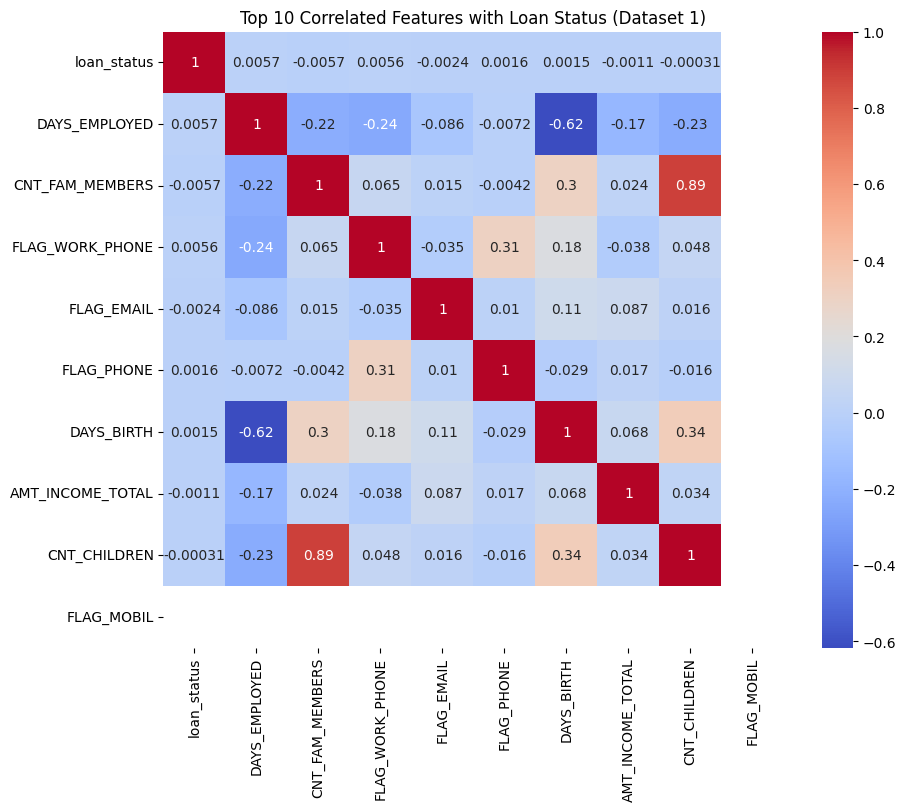

In [10]:
# Select only numeric columns
numeric_df_1 = df_1_full.select_dtypes(include=['int64', 'float64'])

# Compute correlation with loan_status
corr = numeric_df_1.corr()

# Plot top 10 correlated features
plt.figure(figsize=(10, 8))
top_corr = corr['loan_status'].abs().sort_values(ascending=False).head(11)
sns.heatmap(numeric_df_1[top_corr.index].corr(), annot=True, cmap='coolwarm')
plt.title("Top 10 Correlated Features with Loan Status (Dataset 1)")
plt.show()

Dataset 2 - Class Distribution:
 loan_status
0    0.761
1    0.239
Name: proportion, dtype: float64


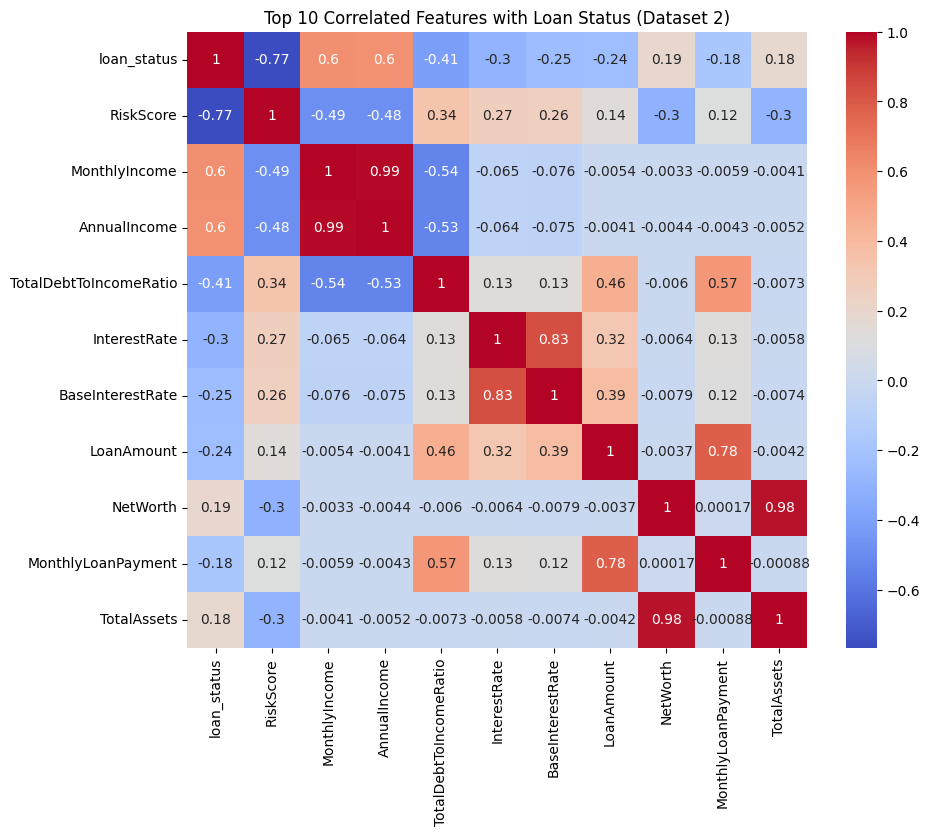

In [11]:
# Dataset 2: Class balance
print("Dataset 2 - Class Distribution:\n", df_2['loan_status'].value_counts(normalize=True))

# Correlation heatmap (top 10)
numeric_df_2 = df_2.select_dtypes(include=['int64', 'float64'])
corr2 = numeric_df_2.corr()

plt.figure(figsize=(10, 8))
top_corr2 = corr2['loan_status'].abs().sort_values(ascending=False).head(11)
sns.heatmap(numeric_df_2[top_corr2.index].corr(), annot=True, cmap='coolwarm')
plt.title("Top 10 Correlated Features with Loan Status (Dataset 2)")
plt.show()


Dataset 3 - Class Distribution:
 loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64


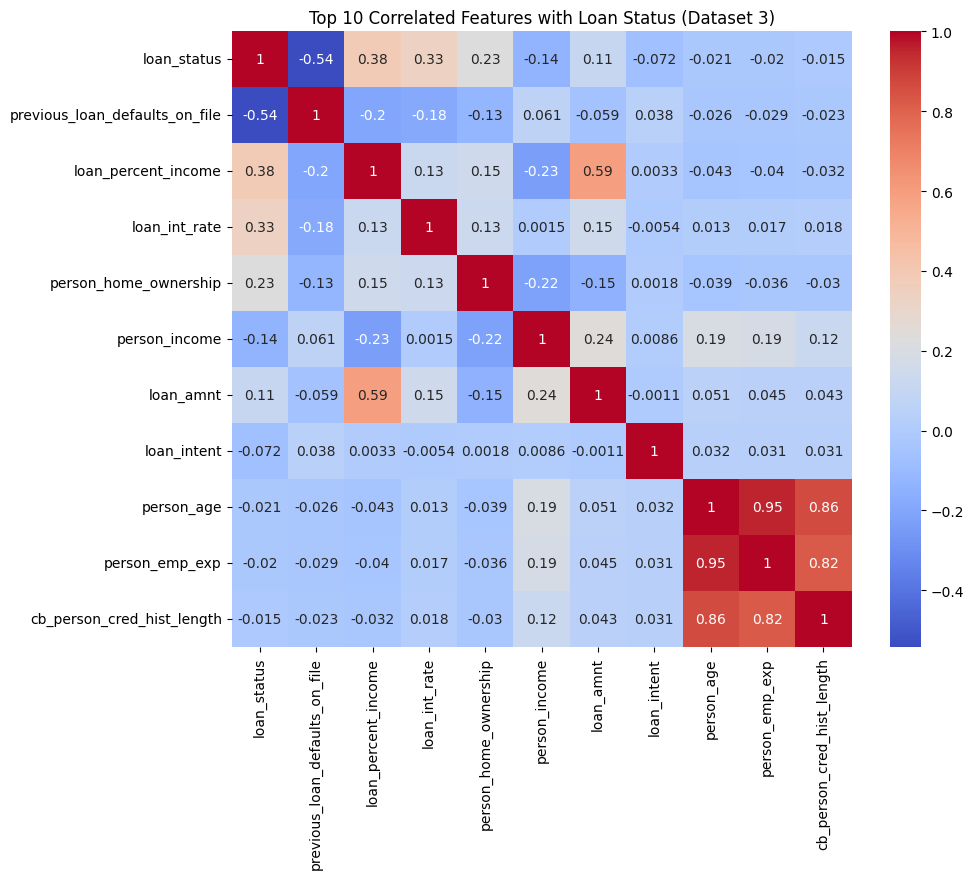

In [12]:
# Dataset 3: Class distribution
print("Dataset 3 - Class Distribution:\n", df_3['loan_status'].value_counts(normalize=True))

# Correlation heatmap (top 10)
numeric_df_3 = df_3.select_dtypes(include=['int64', 'float64'])
corr3 = numeric_df_3.corr()

plt.figure(figsize=(10, 8))
top_corr3 = corr3['loan_status'].abs().sort_values(ascending=False).head(11)
sns.heatmap(numeric_df_3[top_corr3.index].corr(), annot=True, cmap='coolwarm')
plt.title("Top 10 Correlated Features with Loan Status (Dataset 3)")
plt.show()

In [13]:
#Create a summary comparison table across the 3 datasets
summary_data = {
    "Dataset": ["Dataset 1", "Dataset 2", "Dataset 3"],
    "Class Imbalance (loan_status = 1)": [
        f"{df_1_full['loan_status'].mean():.2%}",
        f"{df_2['loan_status'].mean():.2%}",
        f"{df_3['loan_status'].mean():.2%}"
    ],
    "Top Correlated Features": [
        "DAYS_EMPLOYED, CNT_FAM_MEMBERS, WORK_PHONE",
        "RiskScore, MonthlyIncome, TotalDebtToIncomeRatio",
        "PreviousLoanDefaults, LoanPercentIncome, LoanIntRate"
    ]
}

# Convert to DataFrame
df_summary = pd.DataFrame(summary_data)

# Display the summary
print("Dataset Summary:")
display(df_summary)


Dataset Summary:


,Dataset,Class Imbalance (loan_status = 1),Top Correlated Features
0,Dataset 1,1.69%,"DAYS_EMPLOYED, CNT_FAM_MEMBERS, WORK_PHONE"
1,Dataset 2,23.90%,"RiskScore, MonthlyIncome, TotalDebtToIncomeRatio"
2,Dataset 3,22.22%,"PreviousLoanDefaults, LoanPercentIncome, LoanI..."


In [15]:
#Encode all object columns in df_1_full
df_1_model = df_1_full.copy()
le = LabelEncoder()
for col in df_1_model.columns:
    if df_1_model[col].dtype == 'object':
        df_1_model[col] = le.fit_transform(df_1_model[col])


In [16]:
from sklearn.model_selection import train_test_split

#Define X and y
X1 = df_1_model.drop('loan_status', axis=1)
y1 = df_1_model['loan_status']

#Train-test split (using stratify due to imbalance)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

#Logistic Regression
lr1 = LogisticRegression(class_weight='balanced', max_iter=1000)
lr1.fit(X1_train, y1_train)
y1_pred_lr = lr1.predict(X1_test)

print("Logistic Regression - Dataset 1")
print(classification_report(y1_test, y1_pred_lr))
print("ROC-AUC:", roc_auc_score(y1_test, lr1.predict_proba(X1_test)[:, 1]))

#Random Forest
rf1 = RandomForestClassifier(class_weight='balanced', random_state=42)
rf1.fit(X1_train, y1_train)
y1_pred_rf = rf1.predict(X1_test)

print("\nRandom Forest - Dataset 1")
print(classification_report(y1_test, y1_pred_rf))
print("ROC-AUC:", roc_auc_score(y1_test, rf1.predict_proba(X1_test)[:, 1]))

#XGBoost 
xgb1 = XGBClassifier(scale_pos_weight=(y1_train == 0).sum() / (y1_train == 1).sum(), use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb1.fit(X1_train, y1_train)
y1_pred_xgb = xgb1.predict(X1_test)

print("\nXGBoost - Dataset 1")
print(classification_report(y1_test, y1_pred_xgb))
print("ROC-AUC:", roc_auc_score(y1_test, xgb1.predict_proba(X1_test)[:, 1]))

Logistic Regression - Dataset 1
              precision    recall  f1-score   support

           0       0.99      0.61      0.75      7175
           1       0.02      0.47      0.04       117

    accuracy                           0.60      7292
   macro avg       0.50      0.54      0.39      7292
weighted avg       0.97      0.60      0.74      7292

ROC-AUC: 0.574484052532833

Random Forest - Dataset 1
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7175
           1       0.23      0.40      0.29       117

    accuracy                           0.97      7292
   macro avg       0.61      0.69      0.64      7292
weighted avg       0.98      0.97      0.97      7292

ROC-AUC: 0.7378605676166652

XGBoost - Dataset 1
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      7175
           1       0.17      0.46      0.24       117

    accuracy                           0.95    

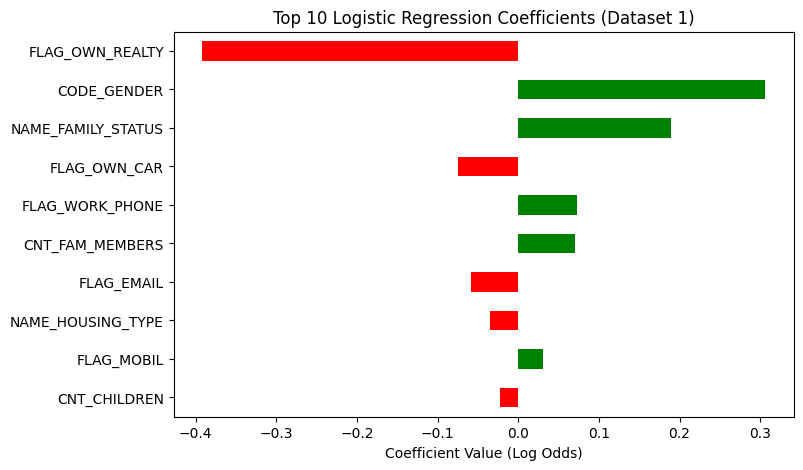

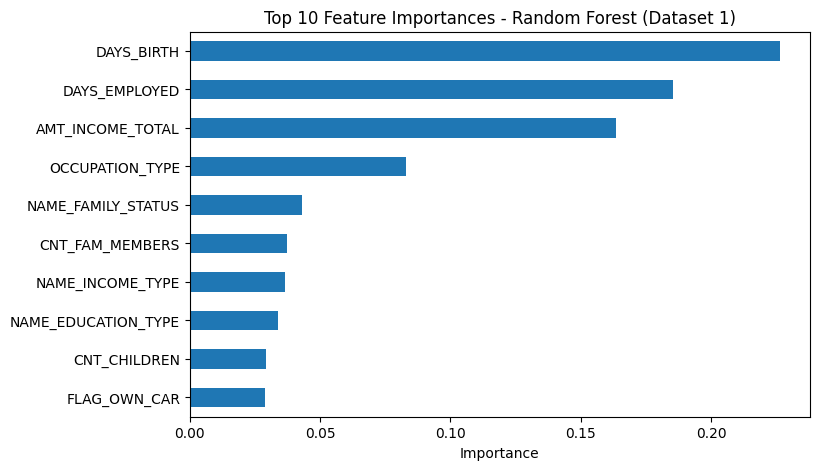

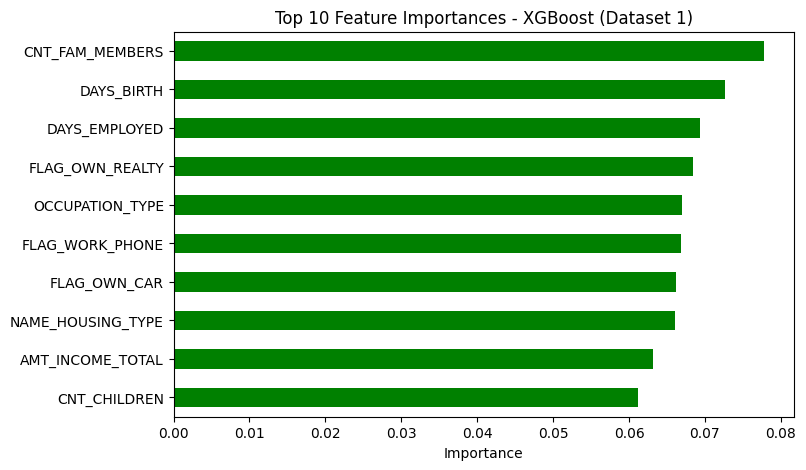

In [17]:
# Get feature importance from logistic regression
coefficients = pd.Series(lr1.coef_[0], index=X1.columns)

# Sort by absolute value
top_coeff = coefficients.abs().sort_values(ascending=False).head(10)
top_signed = coefficients[top_coeff.index]  # retain original sign

# Plot
plt.figure(figsize=(8, 5))
top_signed.plot(kind='barh', color=['green' if v > 0 else 'red' for v in top_signed])
plt.title("Top 10 Logistic Regression Coefficients (Dataset 1)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.gca().invert_yaxis()
plt.show()


#Feature importance from Random Forest
rf_importance = pd.Series(rf1.feature_importances_, index=X1.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
rf_importance.plot(kind='barh')
plt.title("Top 10 Feature Importances - Random Forest (Dataset 1)")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.show()


#Feature importance from XGBoost
xgb_importance = pd.Series(xgb1.feature_importances_, index=X1.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
xgb_importance.plot(kind='barh', color='green')
plt.title("Top 10 Feature Importances - XGBoost (Dataset 1)")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.show()

In [18]:
# Dataset 2: Train/test split
X2 = df_2.drop('loan_status', axis=1)
y2 = df_2['loan_status']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, stratify=y2, random_state=42)

# Logistic Regression
lr2 = LogisticRegression(class_weight='balanced', max_iter=1000)
lr2.fit(X2_train, y2_train)
print("Logistic Regression - Dataset 2")
print(classification_report(y2_test, lr2.predict(X2_test)))
print("ROC-AUC:", roc_auc_score(y2_test, lr2.predict_proba(X2_test)[:, 1]))

# Random Forest
rf2 = RandomForestClassifier(class_weight='balanced', random_state=42)
rf2.fit(X2_train, y2_train)
print("\nRandom Forest - Dataset 2")
print(classification_report(y2_test, rf2.predict(X2_test)))
print("ROC-AUC:", roc_auc_score(y2_test, rf2.predict_proba(X2_test)[:, 1]))

# XGBoost
xgb2 = XGBClassifier(scale_pos_weight=(y2_train == 0).sum() / (y2_train == 1).sum(),
                     use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb2.fit(X2_train, y2_train)
print("\nXGBoost - Dataset 2")
print(classification_report(y2_test, xgb2.predict(X2_test)))
print("ROC-AUC:", roc_auc_score(y2_test, xgb2.predict_proba(X2_test)[:, 1]))


Logistic Regression - Dataset 2
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      3044
           1       0.79      0.92      0.85       956

    accuracy                           0.92      4000
   macro avg       0.88      0.92      0.90      4000
weighted avg       0.93      0.92      0.92      4000

ROC-AUC: 0.976434538896739

Random Forest - Dataset 2
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3044
           1       0.98      0.97      0.98       956

    accuracy                           0.99      4000
   macro avg       0.99      0.98      0.98      4000
weighted avg       0.99      0.99      0.99      4000

ROC-AUC: 0.9992826618246197

XGBoost - Dataset 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3044
           1       1.00      1.00      1.00       956

    accuracy                           1.00    

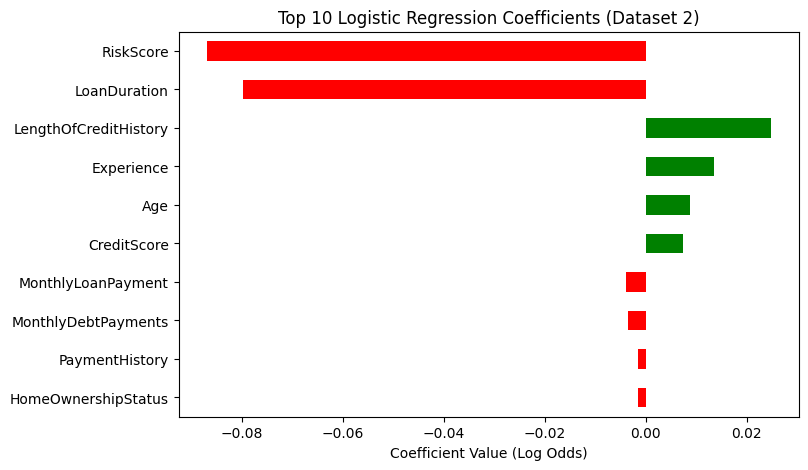

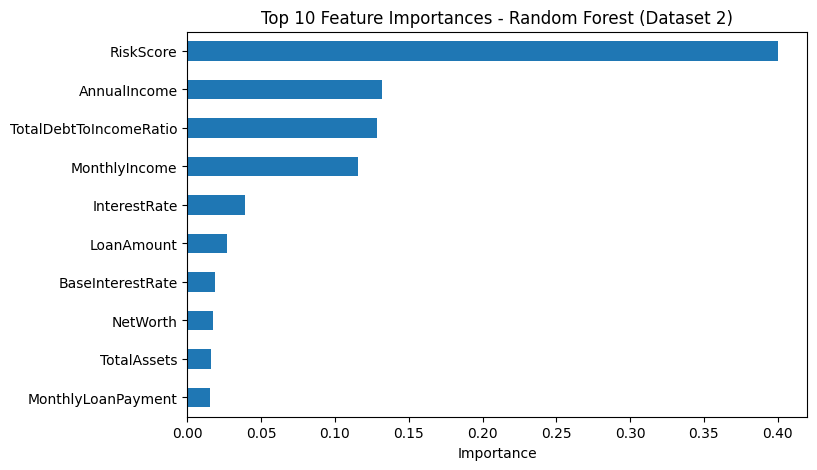

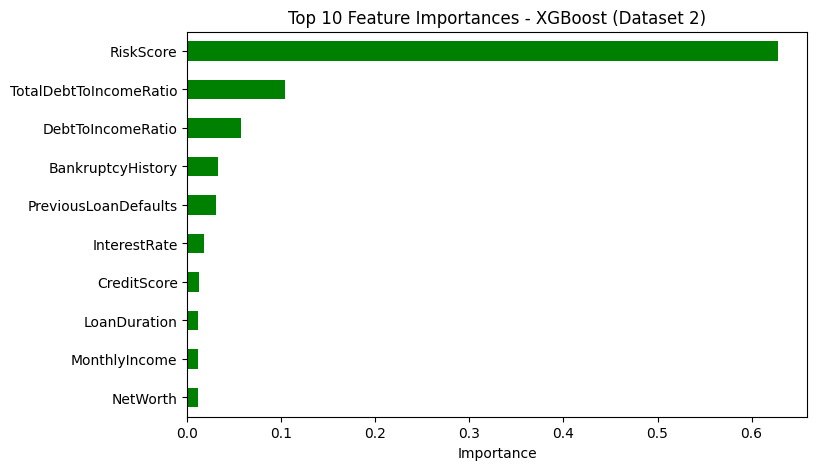

In [19]:
# Logistic Regression Coefficients
coefficients2 = pd.Series(lr2.coef_[0], index=X2.columns)
top_coeff2 = coefficients2.abs().sort_values(ascending=False).head(10)
top_signed2 = coefficients2[top_coeff2.index]

plt.figure(figsize=(8, 5))
top_signed2.plot(kind='barh', color=['green' if v > 0 else 'red' for v in top_signed2])
plt.title("Top 10 Logistic Regression Coefficients (Dataset 2)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.gca().invert_yaxis()
plt.show()

# Random Forest
rf_importance2 = pd.Series(rf2.feature_importances_, index=X2.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
rf_importance2.plot(kind='barh')
plt.title("Top 10 Feature Importances - Random Forest (Dataset 2)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

# XGBoost
xgb_importance2 = pd.Series(xgb2.feature_importances_, index=X2.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
xgb_importance2.plot(kind='barh', color='green')
plt.title("Top 10 Feature Importances - XGBoost (Dataset 2)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


In [20]:
# Dataset 3: Define features and target
X3 = df_3.drop('loan_status', axis=1)
y3 = df_3['loan_status']

# Train-test split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, stratify=y3, random_state=42)

# Logistic Regression
lr3 = LogisticRegression(class_weight='balanced', max_iter=1000)
lr3.fit(X3_train, y3_train)
print("🔹 Logistic Regression - Dataset 3")
print(classification_report(y3_test, lr3.predict(X3_test)))
print("ROC-AUC:", roc_auc_score(y3_test, lr3.predict_proba(X3_test)[:, 1]))

# Random Forest
rf3 = RandomForestClassifier(class_weight='balanced', random_state=42)
rf3.fit(X3_train, y3_train)
print("\n🔹 Random Forest - Dataset 3")
print(classification_report(y3_test, rf3.predict(X3_test)))
print("ROC-AUC:", roc_auc_score(y3_test, rf3.predict_proba(X3_test)[:, 1]))

# XGBoost
xgb3 = XGBClassifier(scale_pos_weight=(y3_train == 0).sum() / (y3_train == 1).sum(),
                     use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb3.fit(X3_train, y3_train)
print("\n🔹 XGBoost - Dataset 3")
print(classification_report(y3_test, xgb3.predict(X3_test)))
print("ROC-AUC:", roc_auc_score(y3_test, xgb3.predict_proba(X3_test)[:, 1]))


🔹 Logistic Regression - Dataset 3
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      7000
           1       0.57      0.92      0.70      2000

    accuracy                           0.83      9000
   macro avg       0.77      0.86      0.79      9000
weighted avg       0.88      0.83      0.84      9000

ROC-AUC: 0.9398495000000001

🔹 Random Forest - Dataset 3
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7000
           1       0.89      0.76      0.82      2000

    accuracy                           0.93      9000
   macro avg       0.91      0.87      0.89      9000
weighted avg       0.92      0.93      0.92      9000

ROC-AUC: 0.9738445

🔹 XGBoost - Dataset 3
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      7000
           1       0.78      0.89      0.83      2000

    accuracy                           0.92      

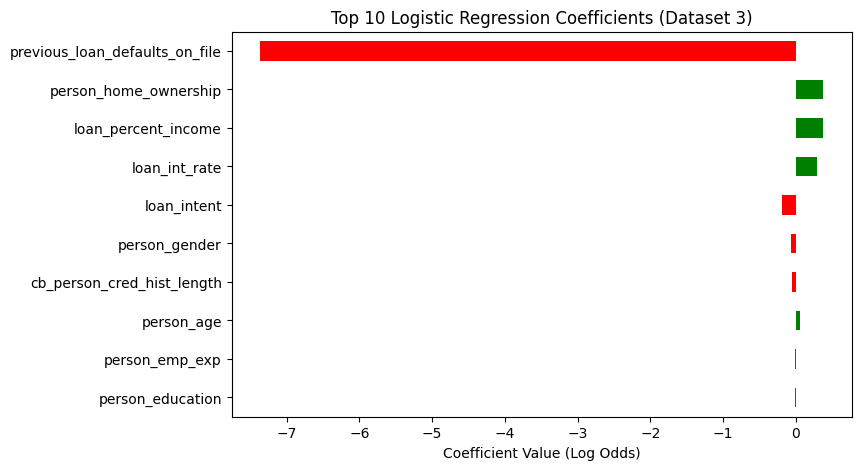

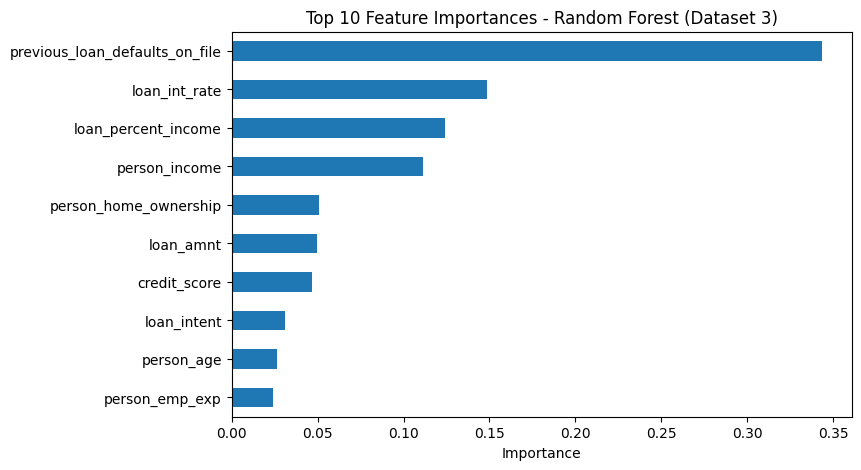

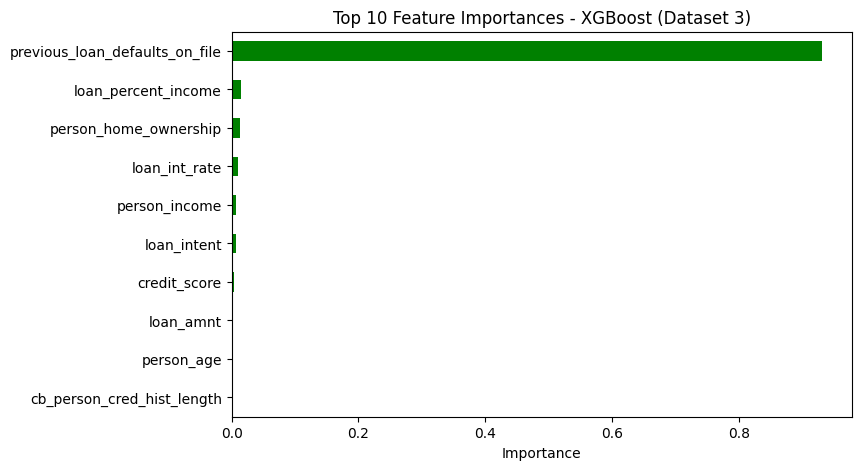

In [21]:
# Logistic Regression
coefficients3 = pd.Series(lr3.coef_[0], index=X3.columns)
top_coeff3 = coefficients3.abs().sort_values(ascending=False).head(10)
top_signed3 = coefficients3[top_coeff3.index]

plt.figure(figsize=(8, 5))
top_signed3.plot(kind='barh', color=['green' if v > 0 else 'red' for v in top_signed3])
plt.title("Top 10 Logistic Regression Coefficients (Dataset 3)")
plt.xlabel("Coefficient Value (Log Odds)")
plt.gca().invert_yaxis()
plt.show()

# Random Forest
rf_importance3 = pd.Series(rf3.feature_importances_, index=X3.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
rf_importance3.plot(kind='barh')
plt.title("Top 10 Feature Importances - Random Forest (Dataset 3)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

# XGBoost
xgb_importance3 = pd.Series(xgb3.feature_importances_, index=X3.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
xgb_importance3.plot(kind='barh', color='green')
plt.title("Top 10 Feature Importances - XGBoost (Dataset 3)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# Create summary data manually
summary_table = pd.DataFrame({
    "Dataset": [
        "Dataset 1", "Dataset 1", "Dataset 1",
        "Dataset 2", "Dataset 2", "Dataset 2",
        "Dataset 3", "Dataset 3", "Dataset 3"
    ],
    "Model": [
        "Logistic Regression", "Random Forest", "XGBoost",
        "Logistic Regression", "Random Forest", "XGBoost",
        "Logistic Regression", "Random Forest", "XGBoost"
    ],
    "Top Features": [
        "FLAG_OWN_REALTY, CODE_GENDER, FAMILY_STATUS",
        "DAYS_BIRTH, DAYS_EMPLOYED, AMT_INCOME_TOTAL",
        "CNT_FAM_MEMBERS, DAYS_BIRTH, FLAG_OWN_REALTY",

        "RiskScore, LoanDuration, LengthOfCreditHistory",
        "RiskScore, AnnualIncome, DebtToIncomeRatio",
        "RiskScore, TotalDebtToIncomeRatio, BankruptcyHistory",

        "PreviousLoanDefaults, HomeOwnership, LoanPercentIncome",
        "PreviousLoanDefaults, LoanIntRate, LoanPercentIncome",
        "PreviousLoanDefaults, LoanPercentIncome, HomeOwnership"
    ]
})

# Display the summary
print("Cross-Dataset Feature Importance Summary:")
display(summary_table)


📊 Cross-Dataset Feature Importance Summary:


,Dataset,Model,Top Features
0,Dataset 1,Logistic Regression,"FLAG_OWN_REALTY, CODE_GENDER, FAMILY_STATUS"
1,Dataset 1,Random Forest,"DAYS_BIRTH, DAYS_EMPLOYED, AMT_INCOME_TOTAL"
2,Dataset 1,XGBoost,"CNT_FAM_MEMBERS, DAYS_BIRTH, FLAG_OWN_REALTY"
3,Dataset 2,Logistic Regression,"RiskScore, LoanDuration, LengthOfCreditHistory"
4,Dataset 2,Random Forest,"RiskScore, AnnualIncome, DebtToIncomeRatio"
5,Dataset 2,XGBoost,"RiskScore, TotalDebtToIncomeRatio, BankruptcyH..."
6,Dataset 3,Logistic Regression,"PreviousLoanDefaults, HomeOwnership, LoanPerce..."
7,Dataset 3,Random Forest,"PreviousLoanDefaults, LoanIntRate, LoanPercent..."
8,Dataset 3,XGBoost,"PreviousLoanDefaults, LoanPercentIncome, HomeO..."


In [25]:
!pip install shap

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/545.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/545.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.1 kB ? eta -:--:--
   ---------------------------------------- 545.1/545.1 kB 1.4 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 1.5 MB/s eta 0:00:02
   ----------- ---------------------------- 0.8/2.8 MB 1.3 MB/s eta 0:00:02
   -------------- ------------------------- 1.0/2.8 MB 1.5 MB/s eta 0:00:02
   ------------------ --------------------- 1.3/2.8 MB 1.6 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 1.3 MB/s eta 0:00:01
   ---------


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


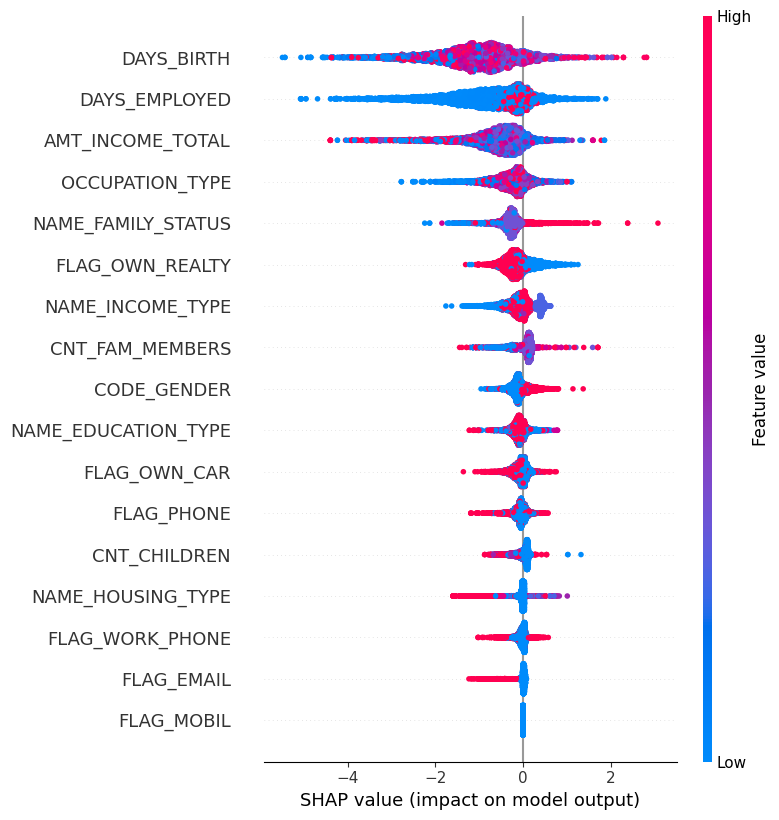

In [26]:
import shap

# SHAP for Dataset 1
explainer1 = shap.Explainer(xgb1)
shap_values1 = explainer1(X1_test)
shap.summary_plot(shap_values1, X1_test)


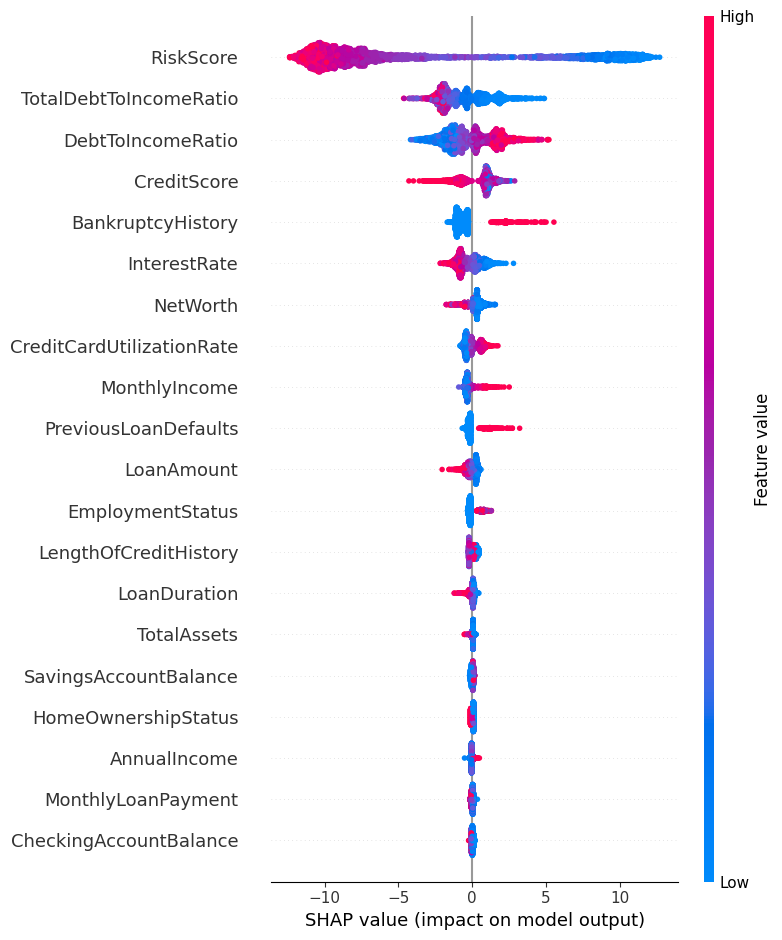

In [27]:
explainer2 = shap.Explainer(xgb2)
shap_values2 = explainer2(X2_test)
shap.summary_plot(shap_values2, X2_test)

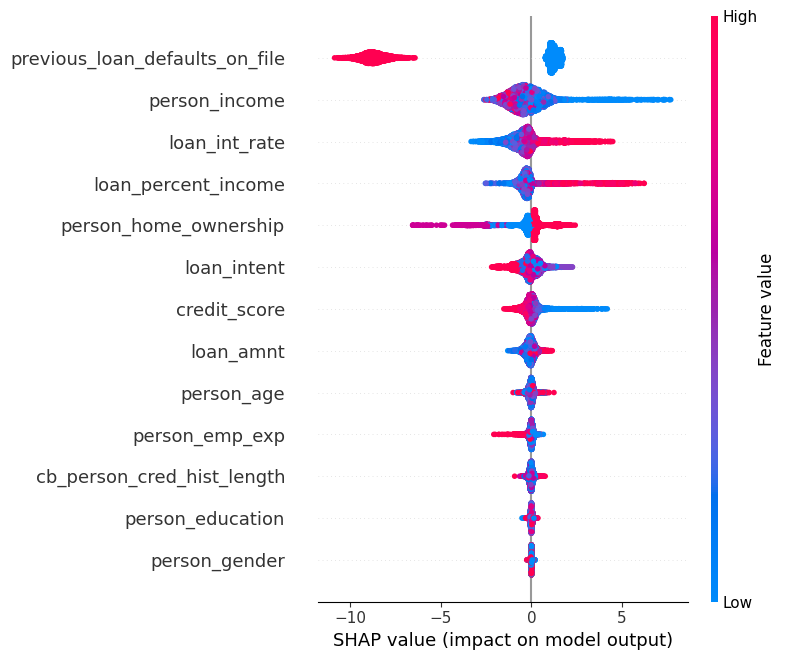

In [28]:
explainer3 = shap.Explainer(xgb3)
shap_values3 = explainer3(X3_test)
shap.summary_plot(shap_values3, X3_test)

In [ ]:
# SHAP takeaways summarized
shap_summary = pd.DataFrame({
    "Dataset": ["Dataset 1", "Dataset 2", "Dataset 3"],
    "Top SHAP Feature": [
        "DAYS_BIRTH",
        "RiskScore",
        "previous_loan_defaults_on_file"
    ],
    "Interpretation": [
        "Older applicants (lower abs DAYS_BIRTH) tend to reduce loan risk",
        "Higher RiskScore strongly reduces approval probability",
        "Previous defaults strongly reduce approval likelihood"
    ]
})

# Display
print(" SHAP-Based Feature Insights Across Datasets:")
display(shap_summary)

📌 SHAP-Based Feature Insights Across Datasets:


,Dataset,Top SHAP Feature,Interpretation
0,Dataset 1,DAYS_BIRTH,Older applicants (lower abs DAYS_BIRTH) tend t...
1,Dataset 2,RiskScore,Higher RiskScore strongly reduces approval pro...
2,Dataset 3,previous_loan_defaults_on_file,Previous defaults strongly reduce approval lik...


In [30]:
import joblib

# Save Logistic, RF, and XGB models for each dataset
joblib.dump(lr1, "model_lr_d1.pkl")
joblib.dump(rf1, "model_rf_d1.pkl")
joblib.dump(xgb1, "model_xgb_d1.pkl")

joblib.dump(lr2, "model_lr_d2.pkl")
joblib.dump(rf2, "model_rf_d2.pkl")
joblib.dump(xgb2, "model_xgb_d2.pkl")

joblib.dump(lr3, "model_lr_d3.pkl")
joblib.dump(rf3, "model_rf_d3.pkl")
joblib.dump(xgb3, "model_xgb_d3.pkl")

['model_xgb_d3.pkl']

In [ ]:
def quick_summary(df, name="Dataset"):
    print(f" {name} Overview")
    print("Shape:", df.shape)
    print("\nMissing values (%):\n", df.isnull().mean() * 100)
    print("\nData types:\n", df.dtypes)
    print("\nUnique values (first 5 columns):")
    for col in df.columns[:5]:
        print(f"- {col}: {df[col].nunique()} unique")

quick_summary(df_1_full, "Dataset 1")
quick_summary(df_2, "Dataset 2")
quick_summary(df_3, "Dataset 3")


📊 Dataset 1 Overview
Shape: (36457, 18)

Missing values (%):
 CODE_GENDER             0.000000
FLAG_OWN_CAR            0.000000
FLAG_OWN_REALTY         0.000000
CNT_CHILDREN            0.000000
AMT_INCOME_TOTAL        0.000000
NAME_INCOME_TYPE        0.000000
NAME_EDUCATION_TYPE     0.000000
NAME_FAMILY_STATUS      0.000000
NAME_HOUSING_TYPE       0.000000
DAYS_BIRTH              0.000000
DAYS_EMPLOYED           0.000000
FLAG_MOBIL              0.000000
FLAG_WORK_PHONE         0.000000
FLAG_PHONE              0.000000
FLAG_EMAIL              0.000000
OCCUPATION_TYPE        31.058507
CNT_FAM_MEMBERS         0.000000
loan_status             0.000000
dtype: float64

Data types:
 CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_